# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

In [2]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1.Define the model class.

In [3]:
class MLP(nn.Module):
    
    def __init__(self, no_features, no_hidden=128, no_labels=1):
        super(MLP, self).__init__()
        
        # Define the MLP stack using nn.Sequential
        self.mlp_stack = nn.Sequential(
            # First hidden layer
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Apply dropout to the first hidden layer

            # Second hidden layer
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Apply dropout to the second hidden layer

            # Third hidden layer
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Apply dropout to the third hidden layer

            # Output layer
            nn.Linear(no_hidden, no_labels),
            nn.Sigmoid()  # Sigmoid activation for the output layer
        )

    def forward(self, x):
        # Pass the input through the network stack
        return self.mlp_stack(x)

#### Divide the dataset into a 80:20 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

2.Split the dataset and do preprocessing.

In [4]:
from common_utils import split_dataset, preprocess_dataset


# Define the preprocessing function
def preprocess(df, col_drop):
    # Columns to drop
    columns_to_drop = col_drop
    
    # Split the dataset (80% train, 20% test)
    X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.2, random_state=1)

    # Scale the features using StandardScaler
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    
    return X_train_scaled, y_train, X_test_scaled, y_test

In [5]:
# Read the dataset
df = pd.read_csv('simplified.csv')

# Create the label from the filename since filename contains the label
df['label'] = df['filename'].str.split('_').str[-2]
df['label'].value_counts()

label
pos    6202
neg    5855
Name: count, dtype: int64

Since we are using the LabelEncoder from scikit-learn, the labels will be automatically encoded alphabetically, 

since neg (n) comes before pos (p), 

- neg will be encoded as 0 
- pos will be encoded as 1

In [6]:
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,label
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803,neg
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572,neg
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824,neg
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389,neg
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966,neg


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12057 entries, 0 to 12056
Data columns (total 79 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   filename             12057 non-null  object 
 1   tempo                12057 non-null  float64
 2   total_beats          12057 non-null  int64  
 3   average_beats        12057 non-null  float64
 4   chroma_stft_mean     12057 non-null  float64
 5   chroma_stft_var      12057 non-null  float64
 6   chroma_cq_mean       12057 non-null  float64
 7   chroma_cq_var        12057 non-null  float64
 8   chroma_cens_mean     12057 non-null  float64
 9   chroma_cens_var      12057 non-null  float64
 10  melspectrogram_mean  12057 non-null  float64
 11  melspectrogram_var   12057 non-null  float64
 12  mfcc_mean            12057 non-null  float64
 13  mfcc_var             12057 non-null  float64
 14  mfcc_delta_mean      12057 non-null  float64
 15  mfcc_delta_var       12057 non-null 

In [8]:
# From the dataset given, we will drop filename and label since filename doesn't provide any detail and label is the prediction task
col_drop = ["filename", "label"]

# Preprocess the dataset (split and scale)
X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df, col_drop= col_drop)

#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

3.Define a Pytorch Dataset and Dataloaders.  

In [9]:
# Define the Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (ndarray): The input features (e.g., X_train_scaled or X_test_scaled).
            y (ndarray): The labels (e.g., y_train or y_test).
        """
        self.X = torch.tensor(X, dtype=torch.float32)  # Convert input features to PyTorch tensors
        self.y = torch.tensor(y, dtype=torch.long)     # Convert labels to PyTorch tensors (long for classification)

    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.X)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to fetch.
        Returns:
            Tuple of (input features, label) for the given index.
        """
        return self.X[idx], self.y[idx]

# Initialize the DataLoaders
def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test, batch_size):
    """
    Args:
        X_train_scaled (ndarray): Scaled input features for training.
        y_train (ndarray): Training labels.
        X_test_scaled (ndarray): Scaled input features for testing.
        y_test (ndarray): Test labels.
        batch_size (int): Batch size for loading the data.

    Returns:
        train_dataloader (DataLoader): Dataloader for the training set.
        test_dataloader (DataLoader): Dataloader for the test set.
    """
    # Create instances of the CustomDataset for training and testing
    train_dataset = CustomDataset(X_train_scaled, y_train)
    test_dataset = CustomDataset(X_test_scaled, y_test)

    # Create DataLoaders for training and testing
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader


4.Next, define the model, optimizer and loss function.

In [10]:
import torch.optim as optim  
from common_utils import EarlyStopper

# Define the parameters for the input_size, hidden_size and output_size

input_size = X_train_scaled.shape[1]  # Number of input features
hidden_size = 128  # Hidden layer size
output_size = 1  # Binary classification (1 output neuron)
learning_rate = 0.001

# Define the model
model = MLP(input_size, hidden_size, output_size)

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# Binary Cross Entropy Loss for binary classification
loss_fn = nn.BCELoss()

# Initialize EarlyStopper with patience and min_delta
early_stopper = EarlyStopper(patience=3, min_delta=0)  


5.Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [11]:
# Training loop with early stopping using the EarlyStopper class
def train_model(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, labels) in enumerate(train_dataloader):
            data, labels = data.to(device), labels.to(device).float()  # Ensure labels are float for BCELoss

            # Forward pass
            outputs = model(data).squeeze()
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate accuracy on the training batch
            predicted = (outputs > 0.5).float()  # Predictions thresholded at 0.5
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss /= len(train_dataloader)
        train_accuracy = correct_train / total_train

        # Store train loss and accuracy
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validate the model
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data, labels in test_dataloader:
                data, labels = data.to(device), labels.to(device).float()

                outputs = model(data).squeeze()
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy on the validation batch
                predicted = (outputs > 0.5).float()  # Predictions thresholded at 0.5
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(test_dataloader)
        val_accuracy = correct_val / total_val

        # Store validation loss and accuracy
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

        # Check if early stopping is triggered
        if early_stopper.early_stop(val_loss):
            print(f'Early stopping at epoch {epoch+1}')
            break

    return train_losses, val_losses, train_accuracies, val_accuracies


In [15]:
# Preparing the train_dataloader and test_dataloader
train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test, batch_size=128)

# Training the model and getting the results
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_dataloader, test_dataloader, optimizer, loss_fn)

Epoch 1/100 - Train Loss: 0.6848, Val Loss: 0.6760, Train Acc: 0.5468, Val Acc: 0.5717
Epoch 2/100 - Train Loss: 0.6649, Val Loss: 0.6584, Train Acc: 0.5972, Val Acc: 0.6111
Epoch 3/100 - Train Loss: 0.6484, Val Loss: 0.6446, Train Acc: 0.6153, Val Acc: 0.6211
Epoch 4/100 - Train Loss: 0.6345, Val Loss: 0.6301, Train Acc: 0.6329, Val Acc: 0.6488
Epoch 5/100 - Train Loss: 0.6109, Val Loss: 0.6076, Train Acc: 0.6630, Val Acc: 0.6621
Epoch 6/100 - Train Loss: 0.5929, Val Loss: 0.6041, Train Acc: 0.6733, Val Acc: 0.6729
Epoch 7/100 - Train Loss: 0.5758, Val Loss: 0.5885, Train Acc: 0.6925, Val Acc: 0.6895
Epoch 8/100 - Train Loss: 0.5583, Val Loss: 0.5857, Train Acc: 0.7103, Val Acc: 0.6936
Epoch 9/100 - Train Loss: 0.5446, Val Loss: 0.5708, Train Acc: 0.7187, Val Acc: 0.6986
Epoch 10/100 - Train Loss: 0.5259, Val Loss: 0.5610, Train Acc: 0.7337, Val Acc: 0.7135
Epoch 11/100 - Train Loss: 0.5138, Val Loss: 0.5495, Train Acc: 0.7378, Val Acc: 0.7185
Epoch 12/100 - Train Loss: 0.4979, Val Lo

#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


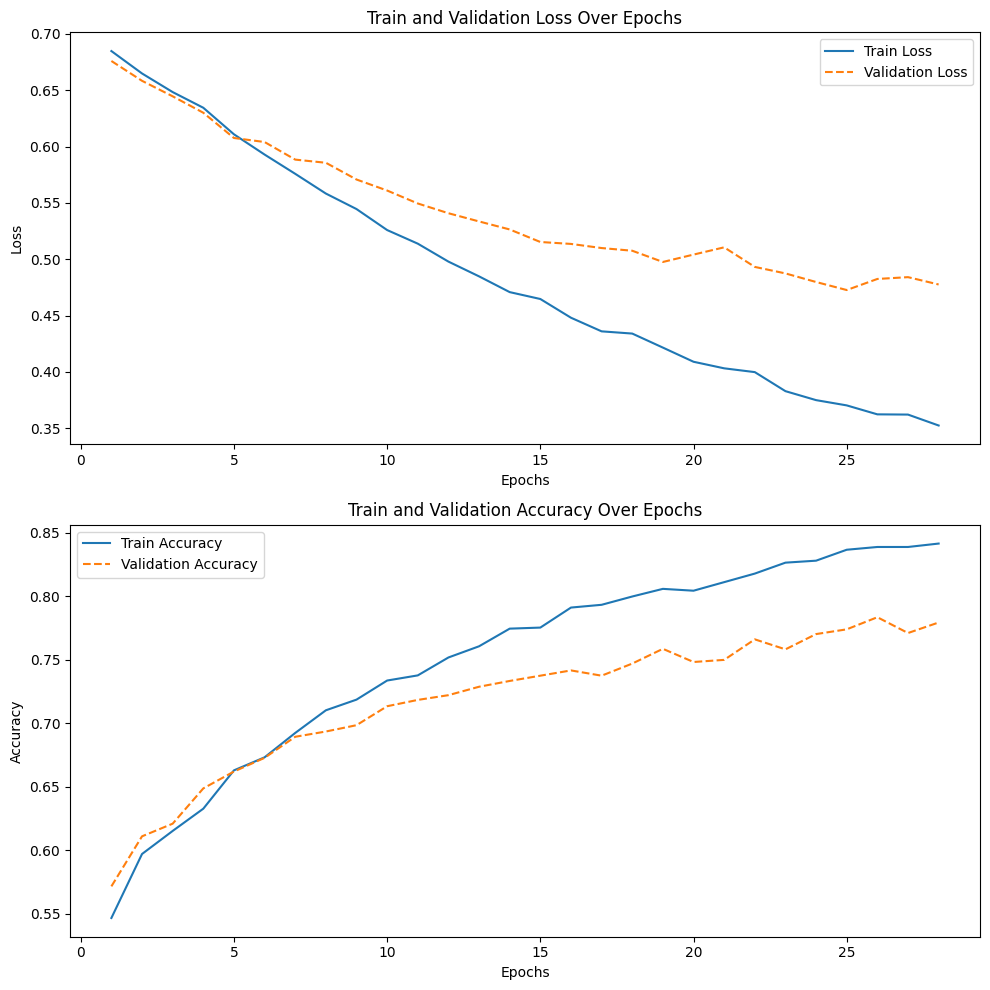

In [16]:
# Plot the losses and accuracies
epochs = len(train_losses)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot 1: Train and Validation Loss
axs[0].plot(range(1, epochs + 1), train_losses, label="Train Loss")
axs[0].plot(range(1, epochs + 1), val_losses, label="Validation Loss", linestyle='--')
axs[0].set_title('Train and Validation Loss Over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot 2: Train and Validation Accuracy
axs[1].plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy")
axs[1].plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy", linestyle='--')
axs[1].set_title('Train and Validation Accuracy Over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()


6.Comment on line plots.

### Comment 

##### Train and Validation Loss

- The training loss is consistently decreasing over the epochs, which tells us that the model is learning from the training data and minimizing the loss function 
- The downward trend also tells us that the optimizier is effectively updating the weights to reduce the error on the training set

- The validation loss is also decreasing at a slower rate, this tells us that the model is generalizing and not overfitting given that the gap between the training and validation losses remains relatively small. 

- Near the end of the training, around the 20th epoch, the validation loss flattens while the training loss continous to decrease. This could indicate that the model might begin to overfit if training continues, as the model is improving on the training data without an improvement on the test data. 

##### Train and Validation Accuracy

- The training accuracy is improving consistently over each epochs. This suggest that the model is learning effectively on the patterns in the training data. 
- The smooth upward trend indicates that the optimizier is working well to minimize the error and increase accuracy on the training set. 

- The validation accuracy shows a similar trend, increasing steadily, but at a slower pace. 
- Similar to the Validation loss, the validation accuracy flattens out near the end of the epoch. 

- The gap between the training and validation accuracy is relatively small, which is good as it indicates that the model is not overfitting significantly. 


##### Conclusion 

- The model seems to be trained well and able to generalise the task as since seem from the relatively similar performance betweeen the validaiton set and the training set. Early Stopping is implemented and it shows that it is able to prevent overfitting of the model. 
